In [1]:
# 0. Installation
# !pip uninstall -y transformers huggingface-hub tokenizers safetensors
# !pip install transformers==4.31.0 --no-cache-dir


In [2]:
# 1. Imports and setup
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# 2. Device & checkpoint directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [4]:
# 3. Load and split data
train_file = os.path.join(checkpoint_dir, "train.pkl")
val_file = os.path.join(checkpoint_dir, "val.pkl")
test_file = os.path.join(checkpoint_dir, "test.pkl")

if os.path.exists(train_file):
    print("Loading saved splits")
    train_texts, train_labels = load_pickle(train_file)
    val_texts, val_labels = load_pickle(val_file)
    test_texts, test_labels = load_pickle(test_file)
else:
    df = pd.read_csv("IMDB Dataset.csv")
    df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['review'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label'])

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.1, random_state=42, stratify=train_labels)

    save_pickle((train_texts, train_labels), train_file)
    save_pickle((val_texts, val_labels), val_file)
    save_pickle((test_texts, test_labels), test_file)

print(f"Train: {len(train_texts)} | Val: {len(val_texts)} | Test: {len(test_texts)}")


Train: 36000 | Val: 4000 | Test: 10000


In [5]:
# 4. Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_and_cache(texts, split_name):
    cache_path = os.path.join(checkpoint_dir, f"{split_name}_encodings.pkl")
    if os.path.exists(cache_path):
        return load_pickle(cache_path)
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
    save_pickle(encodings, cache_path)
    return encodings

train_encodings = tokenize_and_cache(train_texts, "train")
val_encodings = tokenize_and_cache(val_texts, "val")
test_encodings = tokenize_and_cache(test_texts, "test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
# 5. Dataset Classes: used for teacher training and test evaluation
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
# 6. Teacher Model Training
teacher_model_path = os.path.join(checkpoint_dir, "teacher_model")

if os.path.exists(teacher_model_path):
    print("Loading trained teacher model")
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_path).to(device)
else:
    teacher_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
    optimizer = AdamW(teacher_model.parameters(), lr=5e-5)

    train_loader = DataLoader(IMDbDataset(train_encodings, train_labels), batch_size=8, shuffle=True)

    teacher_model.train()
    for batch in tqdm(train_loader, desc="Training Teacher"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = teacher_model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    teacher_model.save_pretrained(teacher_model_path)
    tokenizer.save_pretrained(teacher_model_path)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Teacher: 100%|██████████| 4500/4500 [55:19<00:00,  1.36it/s]


In [8]:
# 7. Generate Soft Labels
soft_label_path = os.path.join(checkpoint_dir, "soft_labels.pt")
if os.path.exists(soft_label_path):
    soft_labels = torch.load(soft_label_path)
else:
    teacher_model.eval()
    soft_logits = []
    with torch.no_grad():
        for batch in DataLoader(IMDbDataset(train_encodings, train_labels), batch_size=8, shuffle=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = teacher_model(**inputs)
            soft_logits.append(outputs.logits.cpu())
    soft_labels = torch.cat(soft_logits)
    torch.save(soft_labels, soft_label_path)

In [9]:
# 8. Student Model Definition
from transformers import DistilBertModel

class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        return self.classifier(self.dropout(cls_output))


In [10]:
# 9. Distillation Dataset & Training
class DistillIMDbDataset(Dataset):
    def __init__(self, encodings, labels, soft_logits):
        self.encodings = encodings
        self.labels = labels
        self.soft_logits = soft_logits

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['soft_labels'] = self.soft_logits[idx]
        return item

    def __len__(self):
        return len(self.labels)

distill_dataset = DistillIMDbDataset(train_encodings, train_labels, soft_labels)
distill_loader = DataLoader(distill_dataset, batch_size=8, shuffle=False)

student_model = StudentModel().to(device)
optimizer = AdamW(student_model.parameters(), lr=5e-5)
temperature = 2.0
alpha = 0.5

num_epochs = 1
for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(distill_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        teacher_logits = batch['soft_labels'].to(device)

        student_logits = student_model(input_ids)
        loss_ce = F.cross_entropy(student_logits, labels)
        student_soft = F.log_softmax(student_logits / temperature, dim=1)
        teacher_soft = F.softmax(teacher_logits / temperature, dim=1)
        loss_kd = F.kl_div(student_soft, teacher_soft, reduction="batchmean")

        loss = alpha * loss_ce + (1 - alpha) * (temperature ** 2) * loss_kd

        if epoch == 0 and batch_idx == 0:
            print("Student logits:", student_logits[:2])
            print("Ground truth labels:", labels[:2])
            print("Teacher soft probs:", teacher_soft[:2])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/1:   0%|          | 0/4500 [00:00<?, ?it/s]

Student logits: tensor([[-0.0053,  0.4445],
        [ 0.2553,  0.2840]], device='cuda:0', grad_fn=<SliceBackward0>)
Ground truth labels: tensor([0, 1], device='cuda:0')
Teacher soft probs: tensor([[0.6152, 0.3848],
        [0.6392, 0.3608]], device='cuda:0')


Epoch 1/1: 100%|██████████| 4500/4500 [29:44<00:00,  2.52it/s]

Epoch 1 Loss: 1017.3104


In [11]:
student_model_path = os.path.join(checkpoint_dir, "student_model.pth")
torch.save(student_model.state_dict(), student_model_path)
print(f"Student model saved to: {student_model_path}")

Student model saved to: checkpoints/student_model.pth


In [12]:
# 10. Evaluation
def evaluate_model(model, loader, name="Model"):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch.get("attention_mask")
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids) if name == "Student" else model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs if name == "Student" else outputs.logits

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")
    return acc, f1, auc

In [13]:
# 11. Run Evaluation & Visualization
test_loader = DataLoader(IMDbDataset(test_encodings, test_labels), batch_size=32)
teacher_metrics = evaluate_model(teacher_model, test_loader, "Teacher")
student_metrics = evaluate_model(student_model, test_loader, "Student")


Teacher Evaluation:
Accuracy:  0.9234
F1 Score:  0.9256
AUC Score: 0.9786

Student Evaluation:
Accuracy:  0.9292
F1 Score:  0.9290
AUC Score: 0.9796


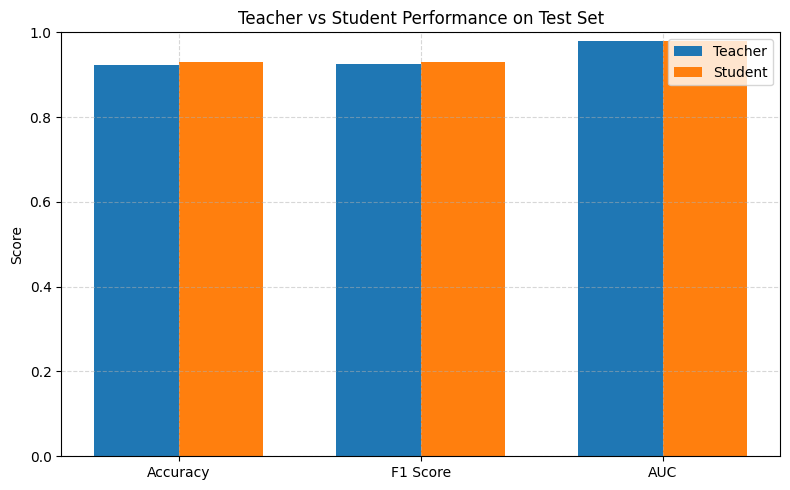

In [14]:
# 12. Plot Comparison
def plot_model_comparison(teacher_metrics, student_metrics):
    labels = ['Accuracy', 'F1 Score', 'AUC']
    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([p - width/2 for p in x], teacher_metrics, width, label='Teacher')
    plt.bar([p + width/2 for p in x], student_metrics, width, label='Student')

    plt.xticks(x, labels)
    plt.ylim(0, 1.0)
    plt.ylabel('Score')
    plt.title('Teacher vs Student Performance on Test Set')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_model_comparison(teacher_metrics, student_metrics)